# 2) Find Shortest Paths with OSMnx

## Env

In [2]:
import osmnx as ox
import networkx as nx
import os
import pandas as pd

In [36]:
# Deifnitions of each
GEO_DEFINITIONS = {
    'phi': [{'county': 'Philadelphia', 'state': 'Pennsylvania'}],
    'chi': [{'county': 'Cook', 'state': 'Illinois'}],
    'sf': [{'county': 'San Francisco','state': 'California'}],
    'eastbay': [{'county': 'Contra Costa','state': 'California'}, {'county': 'Alameda','state': 'California'}],
    'nyc': [{'county': 'King', 'state': 'New York'}, {'county': 'Queens', 'state': 'New York'}, 
            {'county': 'New York', 'state': 'New York'}, {'county': 'Bronx', 'state': 'New York'}]
}

## Mk DB Connection

In [71]:
# Postgres
from dotenv import load_dotenv

load_dotenv()

from sqlalchemy import create_engine
from sqlalchemy.engine import URL
from sqlalchemy import text
# os.chdir('Documents/Grad School/Berkeley/Classes/CYP_204D - Multivariate Analysis in Planning/Project/204d_final_project/')
user = "postgres"
password = os.getenv('POSTGRES_PW')
host = "127.0.0.1"
port = "5432"
database = "gradschool"

pg_url = URL.create(
    drivername='postgresql',
    username='postgres',
    host='127.0.0.1',
    database='gradschool',
    password=os.getenv('POSTGRES_PW')
)

pg_engine = create_engine(pg_url)
# Test connection
try:
    with pg_engine.connect() as connection_str:
        print('Successfully connected to the PostgreSQL database')
except Exception as e:
    print(f'Sorry failed to connect: {e}')

pg_connection = pg_engine.connect()


Successfully connected to the PostgreSQL database


## Network data

### Get Road Networks from OSMnx

In [8]:
G = {}
for i in GEO_DEFINITIONS.keys():
    print(f'Pulling graph for {i}..')
    try:
        G[i] = ox.graph.graph_from_place(GEO_DEFINITIONS[i], network_type='walk', simplify=True, retain_all=False)
        print('\tSuccess..')
    except Exception as e:
        print(f'\tfailed with exception: {e}')

Pulling graph for phi..
	Success..
Pulling graph for chi..
	Success..
Pulling graph for sfba..
	Success..
Pulling graph for nyc..
	failed with exception: Nominatim geocoder returned 0 results for query {'county': 'Kings', 'state': 'New York'}.


In [12]:
# Save them all
import pickle
with open('../data/temp/phi_walk_graph', 'wb') as fp:
    pickle.dump(G['phi'], fp)

with open('../data/temp/chi_walk_graph', 'wb') as fp:
    pickle.dump(G['chi'], fp)

with open('../data/temp/sfba_walk_graph', 'wb') as fp:
    pickle.dump(G['sfba'], fp)

with open('../data/temp/nyc_walk_graph', 'wb') as fp:
    pickle.dump(G['nyc'], fp)


KeyError: 'nyc'

In [73]:
# G.keys()

# Load NYC (downloaded in a different script)
with open('../data/temp/nyc_walk_graph', 'rb') as fp:
    G['nyc'] = pickle.load(fp)

#### Plot All Graphs

Note: I think some of these are just way too big

ValueError: 'grey33' is not a valid color value.

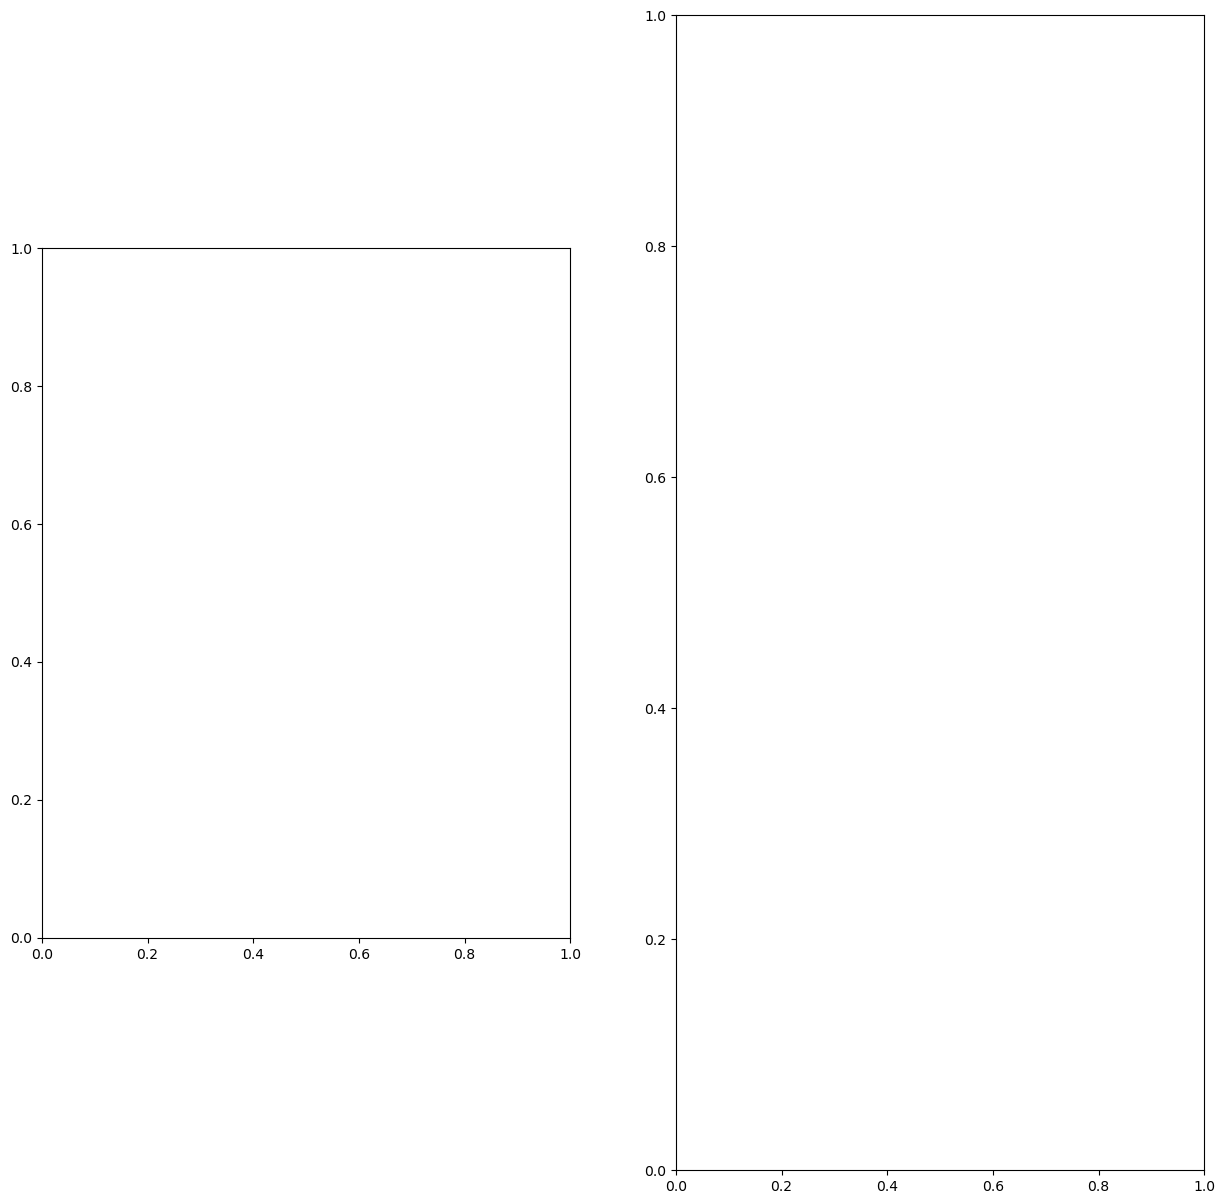

In [79]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 15))

# Plot each graph in a subplot
ox.plot_graph(G['phi'], ax=axes[0], node_size=0, edge_color='grey33', edge_linewidth=.5, show=False)
axes[0].set_title('Philadelphia')

ox.plot_graph(G['chi'], ax=axes[1], node_size=0, edge_color='grey33', edge_linewidth=.5, show=False)
axes[1].set_title('Chicago')

# ox.plot_graph(G['sfba'], ax=axes[1, 0], node_size=0, edge_color='black')
# axes[1, 0].set_title('San Francisco Bay Area')

# ox.plot_graph(G['nyc'], ax=axes[1, 1], node_size=0, edge_color='black')
# axes[1, 1].set_title('New York City')

plt.tight_layout()
plt.show()

In [16]:
sfba_nodes, sfba_edges = ox.graph_to_gdfs(G['sfba'])

In [17]:
sfba_nodes

,y,x,highway,street_count,ref,junction,railway,geometry
osmid,,,,,,,,
25457938,37.007868,-121.553913,traffic_signals,4,NaN,NaN,NaN,POINT (-121.55391 37.00787)
25457939,37.002077,-121.550781,traffic_signals,4,NaN,NaN,NaN,POINT (-121.55078 37.00208)
26392420,36.988574,-121.384907,NaN,4,NaN,NaN,NaN,POINT (-121.38491 36.98857)
26404828,37.006170,-121.552054,traffic_signals,4,NaN,NaN,NaN,POINT (-121.55205 37.00617)
26404847,36.961039,-121.551626,NaN,3,NaN,NaN,NaN,POINT (-121.55163 36.96104)
...,...,...,...,...,...,...,...,...
12483707184,38.031214,-122.265515,NaN,1,NaN,NaN,NaN,POINT (-122.26552 38.03121)
12483707185,38.031025,-122.265464,NaN,1,NaN,NaN,NaN,POINT (-122.26546 38.03103)
12483707186,38.031223,-122.266666,NaN,3,NaN,NaN,NaN,POINT (-122.26667 38.03122)


## Project all to a coordinate system

In [ ]:
# Use Global Mercator for all
PROJ = {
    'phi': 'EPSG:3857', 
    'chi': 'EPSG:3857',
    'sfba': 'EPSG:3857',
    'sf': 'EPSG:3857',
    'eastbay': 'EPSG:3857',
    'nyc': 'EPSG:3857'
}


Gp = {}
for i in G.keys():
    print(f'Projecting {i}..')
    try:
        Gp[i] = ox.projection.project_graph(G[i], to_crs=PROJ[i])
        print('\tSuccess! Now Saving..')
        with open(f'../data/temp/{i}_walk_graph_proj', 'wb') as fp:
            pickle.dump(Gp[i], fp)
    except Exception as e:
        print(e)


Projecting phi..
	Success! Now Saving..
invalid mode: 'wp'
Projecting chi..


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x105d0a0d0>>
Traceback (most recent call last):
  File "/Users/jon/anaconda3/envs/cyp204d/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


## Find Closest node to each centroid

### First reload the centroids

In [9]:
import pickle
with open('../data/temp/bg_centroids', 'rb') as f:
    BG_centroids = pickle.load(f)

## Load Features from OSM

### Bridges
`bridge in ['yes','viaduct']`

In [37]:
#ox.features_from_place(GEO_DEFINITIONS['phi'], tags={'railway': 'rail', 'bridge': 'yes'}).groupby(['railway', 'bridge']).count()
#G_rail_bridges = ox.features_from_place(GEO_DEFINITIONS['phi'], tags={'railway': 'rail'}).groupby('bridge').count()
#phi_feats = ox.features_from_place(GEO_DEFINITIONS['phi'], tags={'bridge':['yes'})
#phi_feats.groupby(['element','highway']).count()
#phi_feats.plot()

phi_bridges = ox.features_from_place(GEO_DEFINITIONS['phi'], tags={'bridge':['yes','viaduct']})
chi_bridges = ox.features_from_place(GEO_DEFINITIONS['chi'], tags={'bridge':['yes','viaduct']})
nyc_bridges = ox.features_from_place(GEO_DEFINITIONS['nyc'], tags={'bridge':['yes','viaduct']})
sf_bridges = ox.features_from_place(GEO_DEFINITIONS['sf'], tags={'bridge':['yes','viaduct']})
eastbay_bridges = ox.features_from_place(GEO_DEFINITIONS['eastbay'], tags={'bridge':['yes','viaduct']})

In [49]:
with open('../data/temp/osm_bridges_phi', 'wb') as fp:
    pickle.dump(phi_bridges, fp)
with open('../data/temp/osm_bridges_chi', 'wb') as fp:
    pickle.dump(chi_bridges, fp)
with open('../data/temp/osm_bridges_nyc', 'wb') as fp:
    pickle.dump(nyc_bridges, fp)
with open('../data/temp/osm_bridges_sf', 'wb') as fp:
    pickle.dump(sf_bridges, fp)
with open('../data/temp/osm_bridges_eastbay', 'wb') as fp:
    pickle.dump(eastbay_bridges, fp)

### Highways
`highway in ['motorway','motorway_link']`
`highway in ['motorway','motorway_link', 'motorway_junction']`

In [55]:
eastbay_bridges['highway'].value_counts()
#eastbay_bridges[eastbay_bridges['highway'].isin(['motorway', 'motorway_link'])].plot

highway
footway           781
motorway          583
service           400
motorway_link     373
secondary         353
residential       261
path              249
tertiary          245
cycleway          176
track             123
primary           113
trunk              69
unclassified       45
steps              28
proposed           11
pedestrian          8
trunk_link          5
secondary_link      3
raceway             2
corridor            2
construction        2
primary_link        1
elevator            1
Name: count, dtype: int64

In [ ]:
# Highways
phi_hwys = ox.features_from_place(GEO_DEFINITIONS['phi'], tags={'highway':['motorway','motorway_link']})
chi_hwys = ox.features_from_place(GEO_DEFINITIONS['chi'], tags={'highway':['motorway','motorway_link']})
nyc_hwys = ox.features_from_place(GEO_DEFINITIONS['nyc'], tags={'highway':['motorway','motorway_link']})
sf_hwys = ox.features_from_place(GEO_DEFINITIONS['sf'], tags={'highway':['motorway','motorway_link']})
eastbay_hwys = ox.features_from_place(GEO_DEFINITIONS['eastbay'], tags={'highway':['motorway','motorway_link']})





Index(['geometry', 'highway', 'ref', 'noref', 'destination', 'destination:ref',
       'oneway', 'surface', 'turn:lanes', 'toll', 'destination:ref:to', 'hgv',
       'lanes', 'maxspeed', 'ref:penndot', 'source:hgv', 'source:ref:penndot',
       'tiger:cfcc', 'bridge', 'layer', 'sidewalk', 'junction:ref',
       'tiger:reviewed', 'bicycle', 'destination:lanes', 'foot', 'horse',
       'lit', 'name', 'maxspeed:advisory', 'old_ref_legislative', 'access',
       'NHS', 'maxheight', 'wikipedia', 'destination:symbol', 'tunnel',
       'destination:to', 'bus', 'tiger:source', 'tiger:tlid',
       'destination:ref:lanes', 'destination:street', 'old_ref:legislative',
       'tiger:name_base', 'tiger:name_base_1', 'tiger:name_type_1',
       'tiger:name_type', 'tiger:zip_left', 'tiger:name_direction_prefix',
       'bridge:name', 'note', 'maxspeed:variable', 'tiger:county', 'highspeed',
       'check_date', 'website', 'destination:street:lanes', 'fixme',
       'embankment', 'ele', 'hgv:lanes', 

<Axes: >

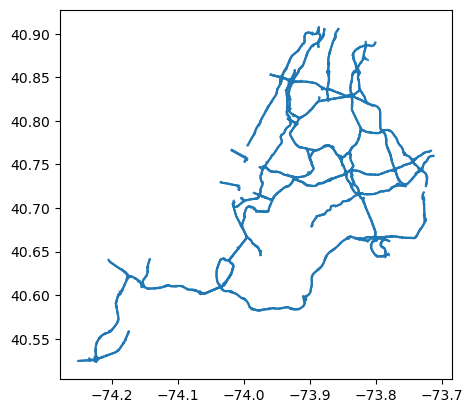

In [ ]:
#eastbay_hwys['bridge'].value_counts(dropna=False)
print(phi_hwys.columns)


nyc_hwys.plot(ax=ax)

In [57]:
with open('../data/temp/osm_hwys_phi', 'wb') as fp:
    pickle.dump(phi_hwys, fp)
with open('../data/temp/osm_hwys_chi', 'wb') as fp:
    pickle.dump(chi_hwys, fp)
with open('../data/temp/osm_hwys_nyc', 'wb') as fp:
    pickle.dump(nyc_hwys, fp)
with open('../data/temp/osm_hwys_sf', 'wb') as fp:
    pickle.dump(sf_hwys, fp)
with open('../data/temp/osm_hwys_eastbay', 'wb') as fp:
    pickle.dump(eastbay_hwys, fp)